# Samsung Capstone EDA

Needed Imports

In [22]:
%pip install pandas torch matplotlib seaborn category_encoders scikit-learn nltk > /dev/null 2>&1

import pandas as pd
import os
import re
import random
pd.set_option('display.max_columns', None)
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns

# Encoders
from category_encoders import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Supervised Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC

# Unsupervised Learning
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# Training Types and Metrics
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report, f1_score, fbeta_score, make_scorer, ConfusionMatrixDisplay

#Ensemble
from sklearn.ensemble import RandomForestClassifier

# Stop Words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Check for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=5679) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrduarte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Some functions
def cleaner(text):
    text = re.sub('[.*?]|\w*\d\w*|\n|https?:\\\S+|www\.\S+|<.*?>+', ' ', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\\W', " ", text)
    return text

def standardize_data(sentence,stopwords):
    treated_tokens=[]
    #convert lower case
    sentence_lower=sentence.lower()
    #tokenize
    word_tokens = word_tokenize(sentence_lower)
    #remove stop words
    #standardize words using stemming or lematization
    for word in word_tokens:
        if word not in stopwords and len(word) > 3:
            word = lemmatizer.lemmatize(word, pos="v")
            treated_tokens.append(word)
    
    # join all the treated tokens again 
    return ' '.join(treated_tokens)

def label_bar_chart(
    input_df: pd.DataFrame, 
    title: str, 
    label: str = None, 
    labels: list = None, 
    colors: list = None,
    normalize_value: bool = True,
    percent_label: bool = False
) -> None:
        
    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df[label].value_counts(normalize=normalize_value)
    
    # Multiply the pertenges x100 and reindex based on lables list
    label_frequencies = label_frequencies.apply(lambda x: x * 100)
    label_frequencies = label_frequencies.reindex(index = labels[::-1])

    # Generate randorm colors:
    if colors is None:
        colors = [
            f"#{random.randint(0, 0xFFFFFF):06x}" for labels in labels
        ]
    
    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(12, 8), color=colors)
    axis.set_title(f"Distribution of {label} values ({title}, sample_size={len(input_df)})", size=20)

    # add percentages
    if percent_label is True:
        axis.bar_label(axis.containers[0], labels=[f'{v:.2f}%' for v in label_frequencies.values], padding=5)


<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_5679/4060915445.py:3: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('[.*?]|\w*\d\w*|\n|https?:\\\S+|www\.\S+|<.*?>+', ' ', text)


## Politifact Fact Check

In [24]:
# Load datataset Politifact Fact Check Dataset
## Repo Link
#politifact=pd.read_csv('https://raw.githubusercontent.com/JaimeFerreira2002/Truthify/refs/heads/main/Datasets/politifact_factcheck_data.json')
## Locally/Codespaces
politifact=pd.read_json(os.path.join('Datasets','politifact_factcheck_data.json'), lines=True)

# Clean the dataset statement text and remove stop_words
#politifact['statement']=politifact['statement'].apply(cleaner)
politifact.insert(
    politifact.columns.get_loc('statement') + 1,
    'statement_no_stopwords',
    politifact['statement'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)

# Convert datetime to data type
politifact['statement_date'] = pd.to_datetime(politifact['statement_date'])
politifact['factcheck_date'] = pd.to_datetime(politifact['factcheck_date'])

politifact.head(5)
politifact.info()

#No null values
#print("Null values:")
#politifact.isnull().sum()

def print_one_row_politifact(index: int) -> None:
    """Relevant collum for analysis"""
    print(f"speaker: {politifact.iat[index, 1]}")
    print(f"statement: {politifact.iat[index, 2]}")
    print(f"source: {politifact.iat[index, 4]}")
    print(f"label: {politifact.iat[index, 0]}")

,verdict,statement_originator,statement,statement_no_stopwords,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,john mccain oppose bankruptcy protections fami...,2008-06-11,speech,Adriel Bettelheim,2008-06-16,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",bennie thompson actively cheer riot,2022-06-07,television,Yacob Reyes,2022-06-13,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",say maggie hassan state days last three months,2016-05-18,news,Clay Wirestone,2016-05-27,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",bust inflate covid number accuse violate federal,2021-02-01,blog,Madison Czopek,2021-02-05,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",republican candidate actually reduce size gove...,2015-08-30,television,Linda Qiu,2015-08-30,https://www.politifact.com/factchecks/2015/aug...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   verdict                  21152 non-null  object        
 1   statement_originator     21152 non-null  object        
 2   statement                21152 non-null  object        
 3   statement_no_stopwords   21152 non-null  object        
 4   statement_date           21152 non-null  datetime64[ns]
 5   statement_source         21152 non-null  object        
 6   factchecker              21152 non-null  object        
 7   factcheck_date           21152 non-null  datetime64[ns]
 8   factcheck_analysis_link  21152 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 1.5+ MB


## Veridict Analysis

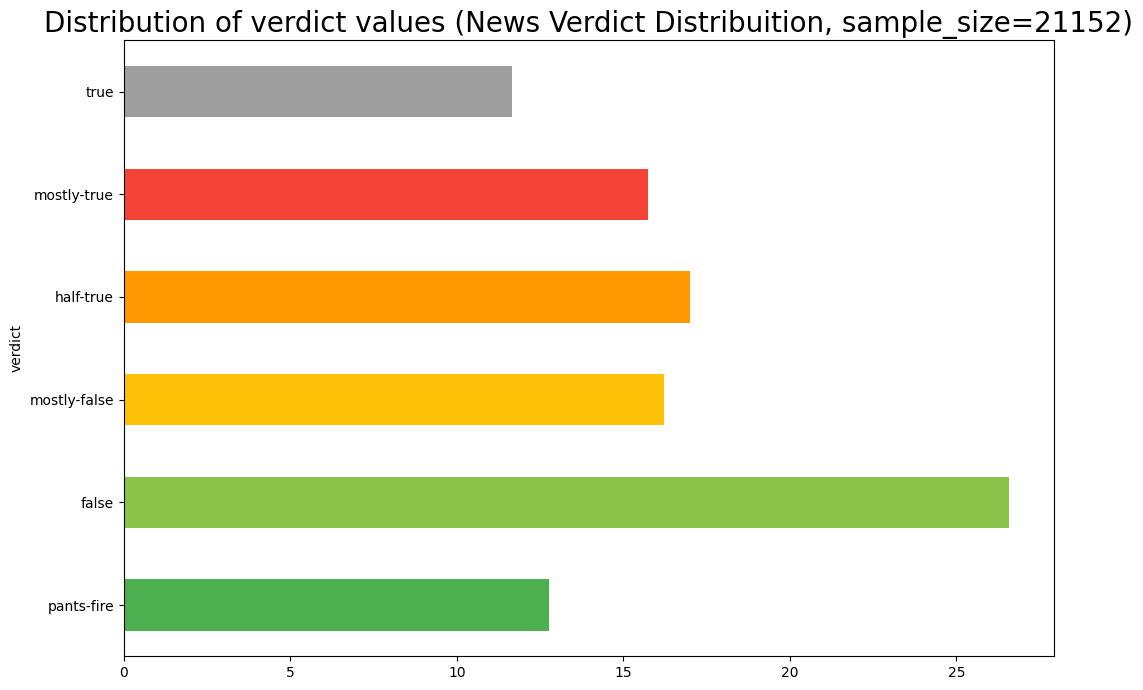

In [25]:
#politifact.verdict.value_counts()
labels = ['true', 'mostly-true', 'half-true', 'mostly-false','false', 'pants-fire']
colors = [
    "#4CAF50",  # True - Green
    "#8BC34A",  # Mostly True - Light Green
    "#FFC107",  # Half True - Yellow
    "#FF9800",  # Mostly False - Orange
    "#F44336",  # False - Red
    "#9E9E9E",  # Pants Fire - Gray
]

label_bar_chart(politifact, "News Verdict Distribuition", "verdict", labels, colors, percent_label=False)

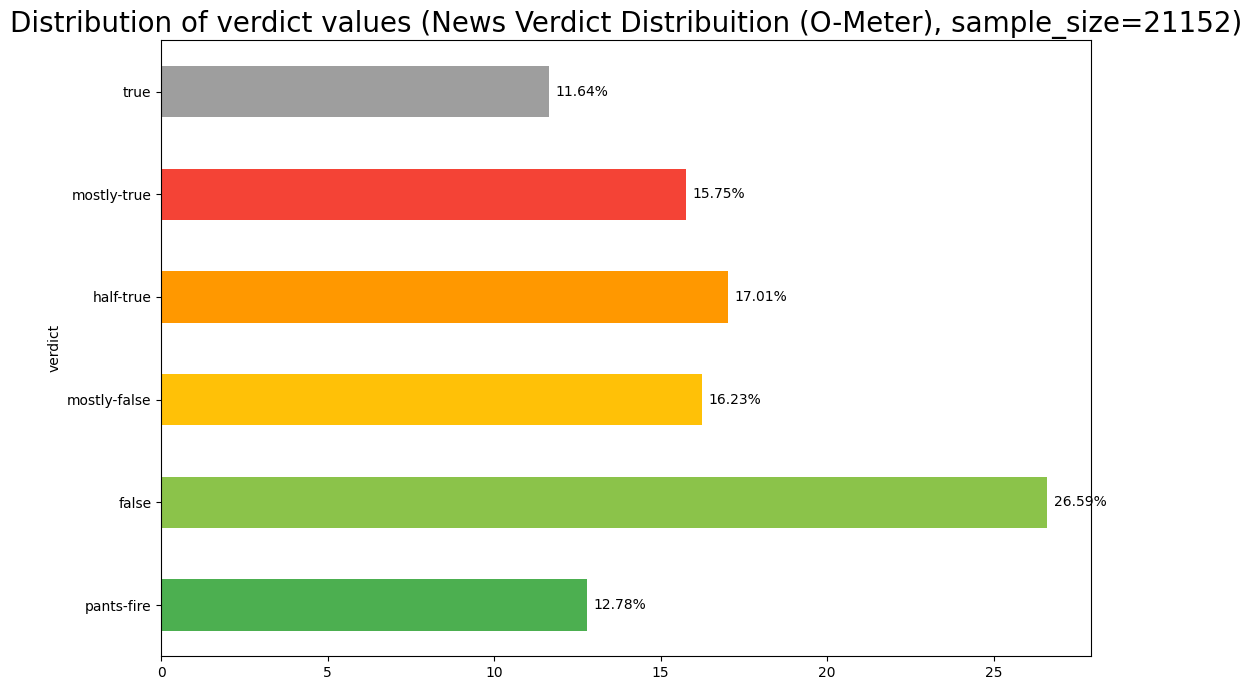

In [26]:
labels = ['true', 'mostly-true', 'half-true', 'mostly-false','false', 'pants-fire']
colors = [
    "#4CAF50",  # True - Green
    "#8BC34A",  # Mostly True - Light Green
    "#FFC107",  # Half True - Yellow
    "#FF9800",  # Mostly False - Orange
    "#F44336",  # False - Red
    "#9E9E9E",  # Pants Fire - Gray
]

label_bar_chart(politifact, "News Verdict Distribuition (O-Meter)", "verdict", labels, colors, percent_label=True)

## Statement Analysis

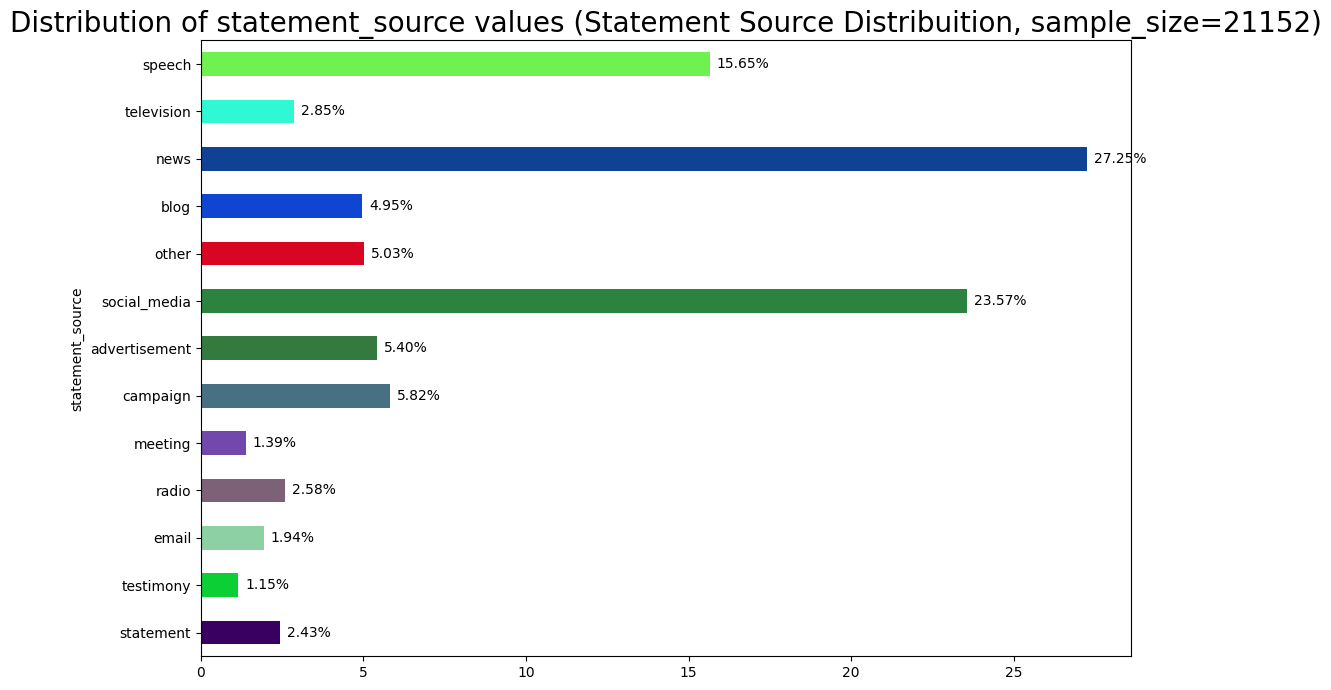

In [27]:
labels = politifact.statement_source.unique().tolist()
label_bar_chart(politifact, "Statement Source Distribuition", "statement_source", labels, percent_label=True)

[Text(0, 0, '9.8%'),
 Text(0, 0, '31.1%'),
 Text(0, 0, '37.2%'),
 Text(0, 0, '55.7%'),
 Text(0, 0, '10.0%'),
 Text(0, 0, '58.3%'),
 Text(0, 0, '20.4%'),
 Text(0, 0, '15.4%'),
 Text(0, 0, '20.8%'),
 Text(0, 0, '60.8%')]

[Text(0, 0, '28.6%'),
 Text(0, 0, '3.3%'),
 Text(0, 0, '12.6%'),
 Text(0, 0, '5.5%'),
 Text(0, 0, '23.0%'),
 Text(0, 0, '5.0%'),
 Text(0, 0, '25.2%'),
 Text(0, 0, '27.7%'),
 Text(0, 0, '19.3%'),
 Text(0, 0, '3.7%')]

[Text(0, 0, '11.4%'),
 Text(0, 0, '7.4%'),
 Text(0, 0, '20.0%'),
 Text(0, 0, '11.7%'),
 Text(0, 0, '13.8%'),
 Text(0, 0, '14.2%'),
 Text(0, 0, '19.5%'),
 Text(0, 0, '17.9%'),
 Text(0, 0, '19.8%'),
 Text(0, 0, '5.6%')]

[Text(0, 0, '29.3%'),
 Text(0, 0, '2.5%'),
 Text(0, 0, '8.8%'),
 Text(0, 0, '2.6%'),
 Text(0, 0, '28.3%'),
 Text(0, 0, '0.8%'),
 Text(0, 0, '24.8%'),
 Text(0, 0, '16.9%'),
 Text(0, 0, '21.8%'),
 Text(0, 0, '1.4%')]

[Text(0, 0, '1.6%'),
 Text(0, 0, '54.5%'),
 Text(0, 0, '17.7%'),
 Text(0, 0, '23.4%'),
 Text(0, 0, '3.3%'),
 Text(0, 0, '21.2%'),
 Text(0, 0, '2.7%'),
 Text(0, 0, '9.7%'),
 Text(0, 0, '5.4%'),
 Text(0, 0, '28.1%')]

[Text(0, 0, '19.4%'),
 Text(0, 0, '1.1%'),
 Text(0, 0, '3.7%'),
 Text(0, 0, '1.1%'),
 Text(0, 0, '21.6%'),
 Text(0, 0, '0.4%'),
 Text(0, 0, '7.5%'),
 Text(0, 0, '12.3%'),
 Text(0, 0, '12.9%'),
 Text(0, 0, '0.4%')]

Text(0.5, 1.0, 'Top 10 Originators of Statements and Their Verdicts (Percentages)')

Text(0.5, 0, 'Percentage of Statements')

Text(0, 0.5, 'Statement Originator')

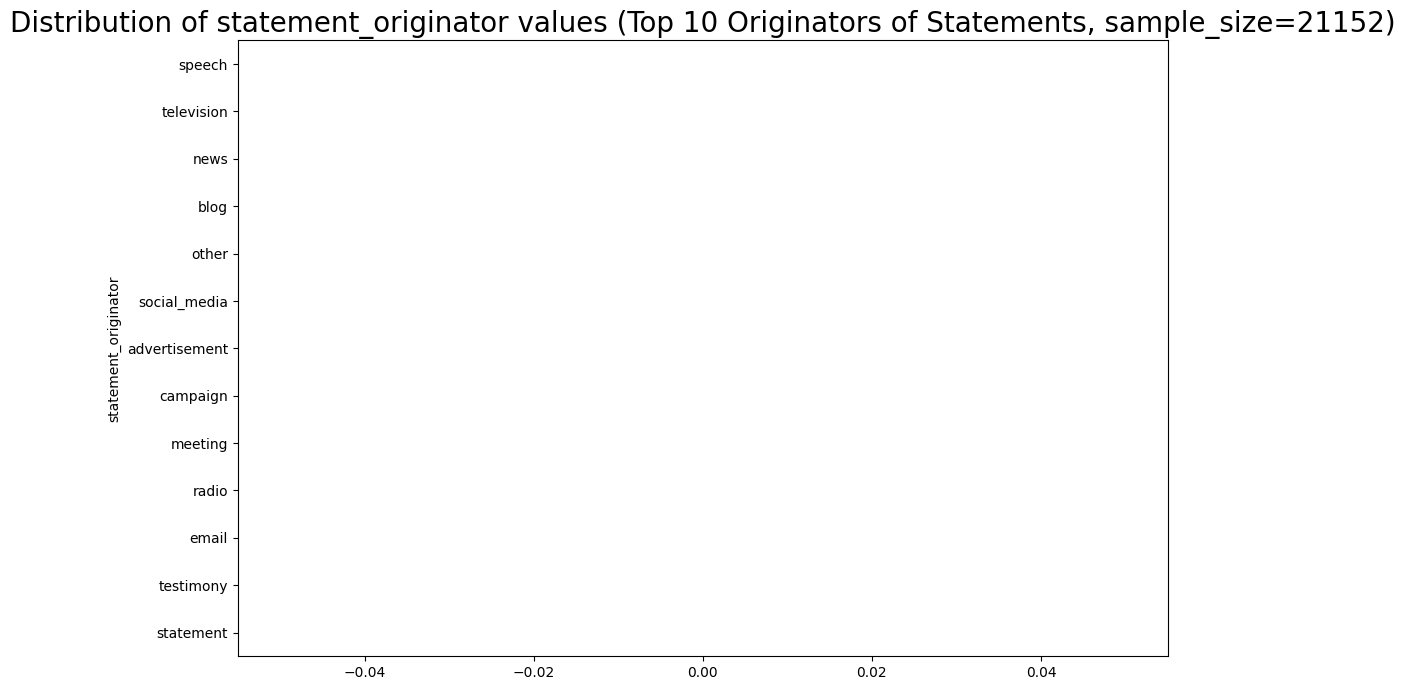

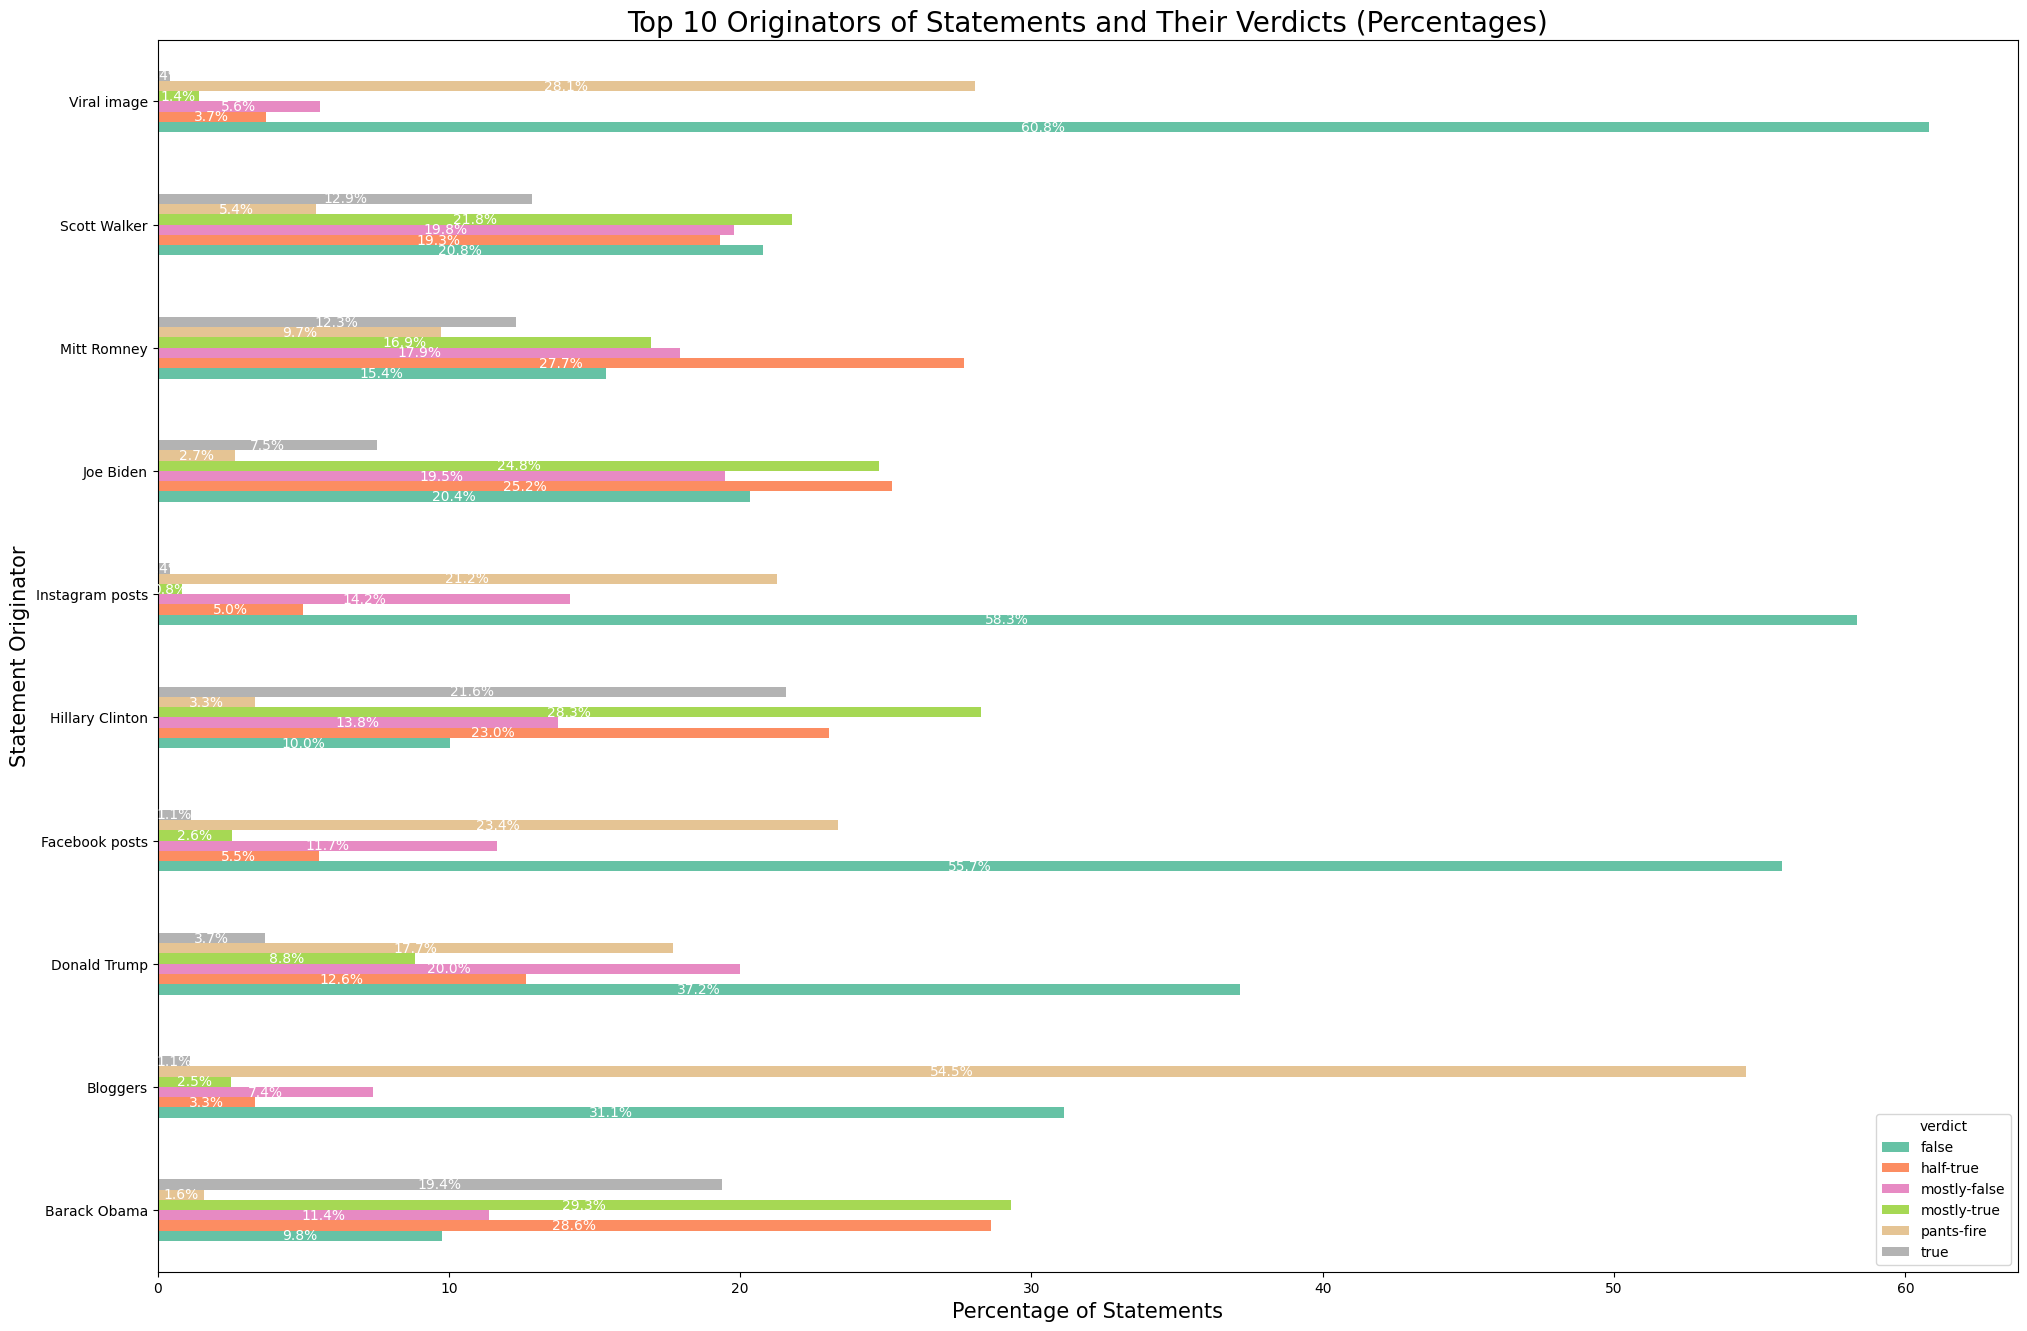

In [28]:
# Get the top 10 originators and their counts
top5_labels = politifact['statement_originator'].value_counts().head(10).tolist()

label_bar_chart(politifact, "Top 10 Originators of Statements", "statement_originator", labels, percent_label=False)

filtered_df = politifact[politifact['statement_originator'].isin(politifact['statement_originator'].value_counts().head(10).index)]
pivot_df = pd.crosstab(filtered_df['statement_originator'], filtered_df['verdict'])
pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plot the data as individual bars for each verdict (not stacked)
ax = pivot_df_percent.plot(kind='barh', figsize=(24, 16), colormap='Set2')

# Add percentages as labels for each bar
for container in ax.containers:
    ax.bar_label(container, label_type='center', labels=[f'{v:.1f}%' for v in container.datavalues], color='white')

# Title and labels
plt.title("Top 10 Originators of Statements and Their Verdicts (Percentages)", size=20)
plt.xlabel("Percentage of Statements", size=15)
plt.ylabel("Statement Originator", size=15)

# Display the plot
plt.show()

We can see the lengh of statements

<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='statement_length', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Statement Lengths')

Text(0.5, 0, 'Statement Length (words)')

Text(0, 0.5, 'Number of Statements')

[Text(0, 5, '68'),
 Text(0, 5, '806'),
 Text(0, 5, '1453'),
 Text(0, 5, '3464'),
 Text(0, 5, '2572'),
 Text(0, 5, '3397'),
 Text(0, 5, '1949'),
 Text(0, 5, '2339'),
 Text(0, 5, '1737'),
 Text(0, 5, '855'),
 Text(0, 5, '921'),
 Text(0, 5, '439'),
 Text(0, 5, '455'),
 Text(0, 5, '199'),
 Text(0, 5, '199'),
 Text(0, 5, '127'),
 Text(0, 5, '44'),
 Text(0, 5, '56'),
 Text(0, 5, '17'),
 Text(0, 5, '22'),
 Text(0, 5, '10'),
 Text(0, 5, '5'),
 Text(0, 5, '9'),
 Text(0, 5, '4'),
 Text(0, 5, '2'),
 Text(0, 5, '0'),
 Text(0, 5, '1'),
 Text(0, 5, '1'),
 Text(0, 5, '0'),
 Text(0, 5, '1')]

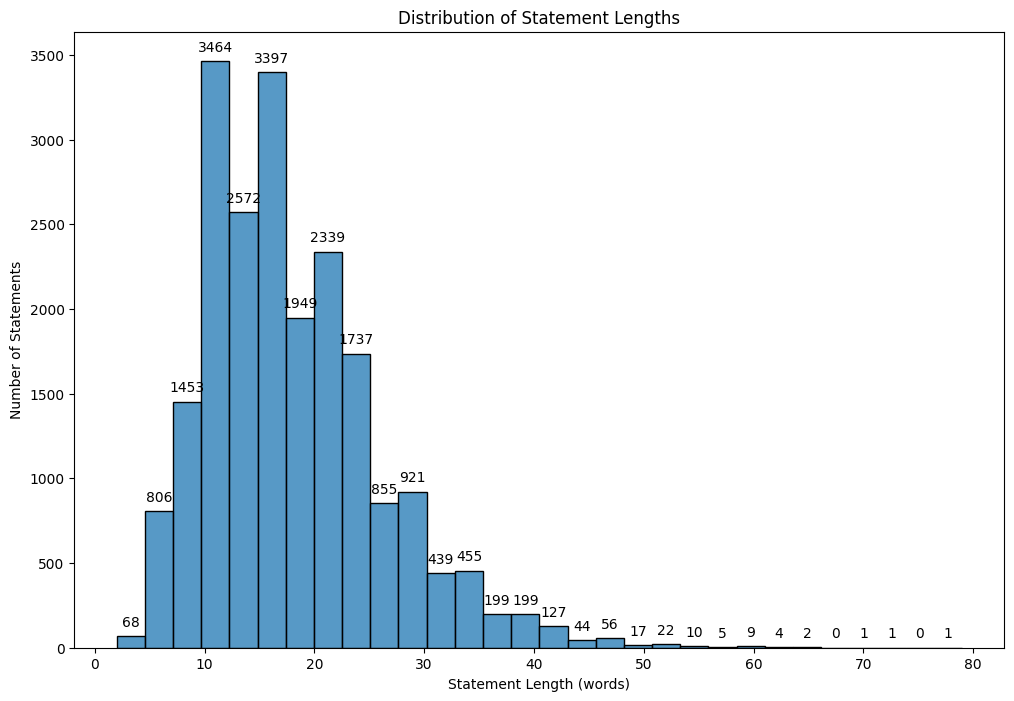

In [29]:
# Statement length
if 'statement_length' not in politifact.columns:
    politifact.insert(
        politifact.columns.get_loc('statement_no_stopwords') + 1,
        'statement_length',
        politifact['statement'].apply(lambda x: len(x.split()))
    )

# Plot histogram
plt.figure(figsize=(12, 8))
sns.histplot(politifact['statement_length'], kde=False, bins=30)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Statement Length (words)')
plt.ylabel('Number of Statements')

# Add labels to bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', padding=5)

plt.show()

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Statement length by verdict')

Text(0.5, 0, 'Verdict')

Text(0, 0.5, 'Statement length')

/tmp/ipykernel_5679/2472216277.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='verdict', y='statement_length', data=politifact, order=veridict_list, palette=dict(zip(veridict_list, colors_veridict)))


<Axes: title={'center': 'Statement length by verdict'}, xlabel='Verdict', ylabel='Statement length'>

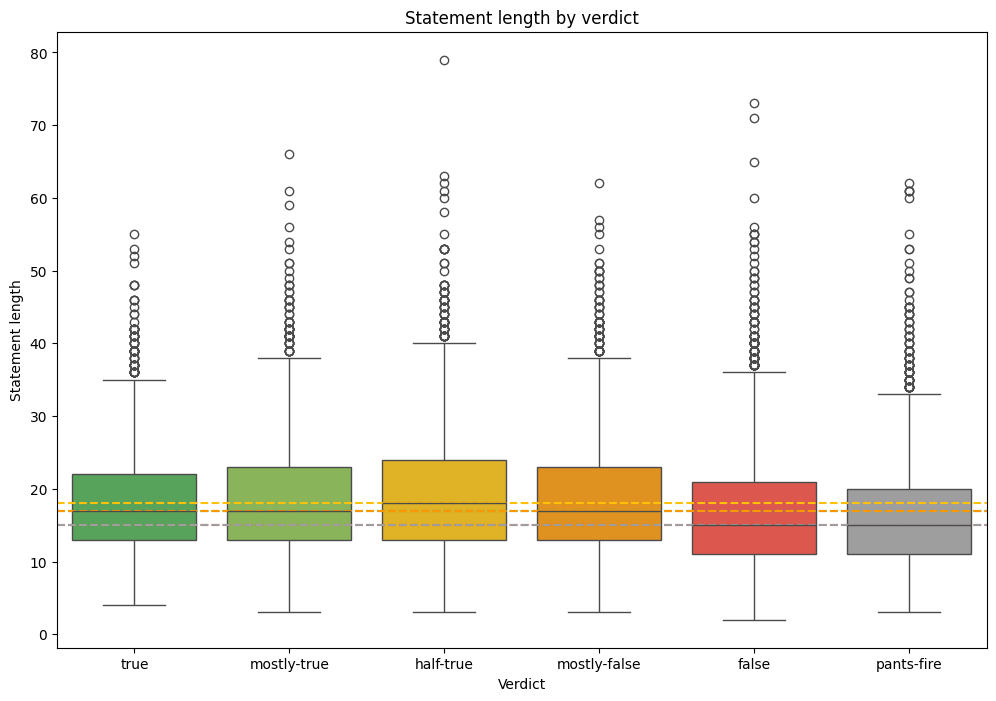

In [30]:
# Statement length by verdict using a boxplot
plt.figure(figsize=(12, 8))
plt.title('Statement length by verdict')
plt.xlabel('Verdict')
plt.ylabel('Statement length')

veridict_list = ['true', 'mostly-true', 'half-true', 'mostly-false','false', 'pants-fire']
colors_veridict = [
    "#4CAF50",  # True - Green
    "#8BC34A",  # Mostly True - Light Green
    "#FFC107",  # Half True - Yellow
    "#FF9800",  # Mostly False - Orange
    "#F44336",  # False - Red
    "#9E9E9E",  # Pants Fire - Gray
]

sns.boxplot(x='verdict', y='statement_length', data=politifact, order=veridict_list, palette=dict(zip(veridict_list, colors_veridict)))

for veridict, color in zip(veridict_list, colors_veridict):
    plt.axhline(politifact[politifact['verdict'] == veridict]['statement_length'].median(), color=color, linestyle='--', label=f"{veridict} median")

plt.show()

## Speaker anaysis
Check the number of existing speaker to check if the dataset is to narrow or not, and avarege statement made by each

In [31]:
unique_speaker=politifact['statement_originator'].nunique()
avg_statement_per_speaker=len(politifact)/unique_speaker

print(f'Unique speaker in dataset: {unique_speaker}')
print(f'Average statement per speaker: {avg_statement_per_speaker:.2f}')

Unique speaker in dataset: 4565
Average statement per speaker: 4.63


We can also make a bar plot that give true-meter for each speaker

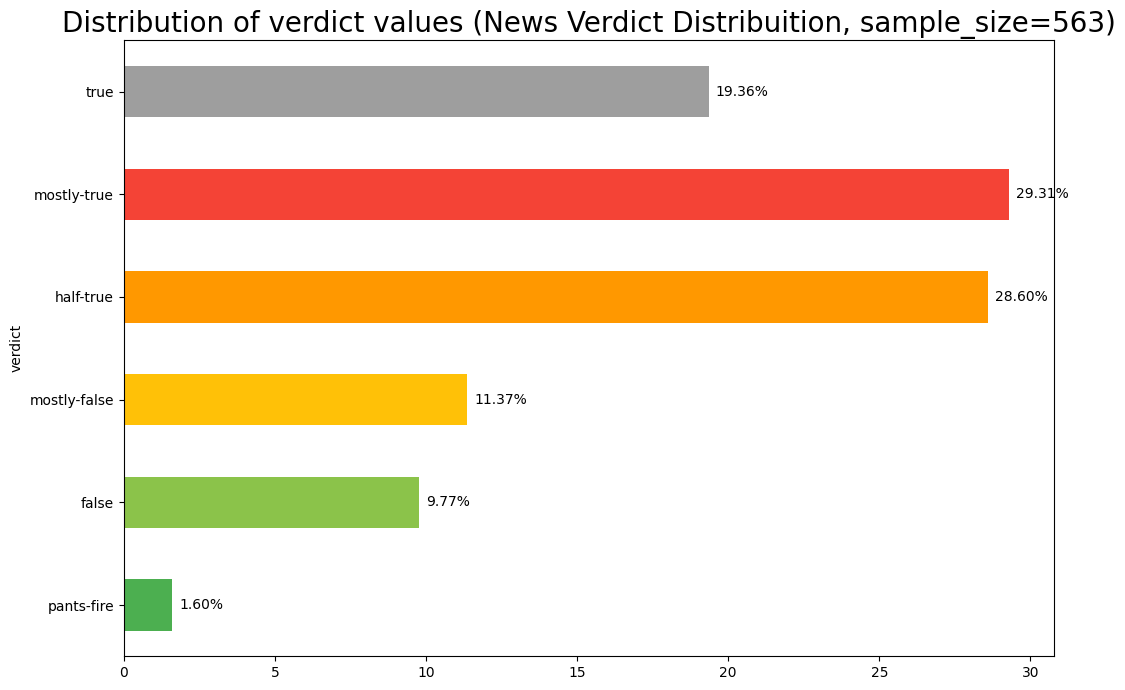

In [32]:
def label_bar_chart_per_speaker(speaker: str, labels: list = None, colors: list = None):
    if labels is None and colors is None:
        labels = ['true', 'mostly-true', 'half-true', 'mostly-false','false', 'pants-fire']
        colors = [
            "#4CAF50",  # True - Green
            "#8BC34A",  # Mostly True - Light Green
            "#FFC107",  # Half True - Yellow
            "#FF9800",  # Mostly False - Orange
            "#F44336",  # False - Red
            "#9E9E9E",  # Pants Fire - Gray
        ]

    speaker_filter=(politifact["statement_originator"] == speaker)
    speaker_polifact = politifact[speaker_filter]

    label_bar_chart(speaker_polifact, "News Verdict Distribuition", "verdict", labels, colors, percent_label=True)

label_bar_chart_per_speaker("Barack Obama")

We can also represent true or false only:

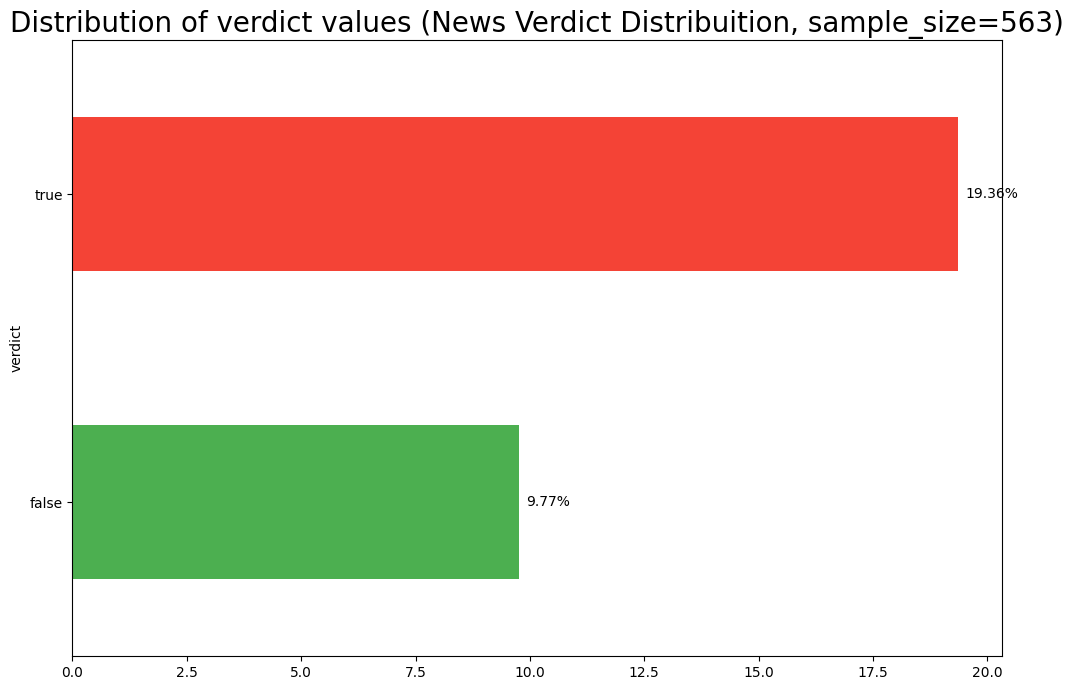

In [33]:
labels = ['true','false']
colors = [
    "#4CAF50",  # True - Green
    "#F44336",  # False - Red
]
label_bar_chart_per_speaker("Barack Obama", labels, colors)

## Snopes Fact-news Data

In [34]:
# Load datataset Snopes Fact-news Data
## Repo Link
#snopes=pd.read_csv('https://raw.githubusercontent.com/JaimeFerreira2002/Truthify/refs/heads/main/Datasets/snopeswithsum.csv')
## Locally/Codespaces
snopes=pd.read_csv(os.path.join('Datasets','snopeswithsum.csv'))

#print("Null values:")
#snopes.isnull().sum()

# Clean the dataset text
snopes.insert(
    snopes.columns.get_loc('question') + 1,
    'question_no_stopwords',
    snopes['question'].apply(lambda x: standardize_data(cleaner(x), stop_words)))

snopes.insert(
    snopes.columns.get_loc('comment') + 1,
    'comment_no_stopwords',
    snopes['comment'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)
snopes.insert(
    snopes.columns.get_loc('claim') + 1,
    'claim_no_stopwords',
    snopes['claim'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)
snopes.insert(
    snopes.columns.get_loc('summary') + 1,
    'summary_no_stopwords',
    snopes['summary'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)

## Fill nan with empty string
snopes["what's true"]=snopes["what's true"].fillna("")
snopes["what's false"]=snopes["what's false"].fillna("")
snopes["what's unknown"]=snopes["what's unknown"].fillna("")

snopes.head(5)
snopes.info()

def print_one_row_snopes(index: int) -> None:
    """Relevant collum for analysis"""
    print(f"question: {snopes.iat[index, 0]}")
    print(f"comment: {snopes.iat[index, 1]}")
    print(f"claim: {snopes.iat[index, 2]}")
    print(f"origin: {snopes.iat[index, 4]}")
    print(f"label: {snopes.iat[index, 7]}")

,question,question_no_stopwords,comment,comment_no_stopwords,claim,claim_no_stopwords,rate,what's true,what's false,what's unknown,origin,summary,summary_no_stopwords
0,Did Kamala Harris Support Abortion Until the T...,kamala harris support abortion time give birth,The Democratic vice-presidential candidate's p...,democratic vice presidential candidate abortio...,"U.S. Sen. Kamala Harris, D-Calif., supports th...",kamala harris calif support ability carry abor...,Mixture,"U.S. Sen. Kamala Harris, D-Calif, has maintain...",She has not explicitly stated that she support...,,Debates surrounding abortion frequently resurf...,"U.S. Sen. Kamala Harris, D-Calif., has been to...",kamala harris calif tout abortion right advoca...
1,Did Hitler Invent the Inflatable Sex Doll?,hitler invent inflatable doll,Nothing attracts curiosity like a lurid combin...,nothing attract curiosity like lurid combinati...,Adolf Hitler was behind the invention of the f...,adolf hitler behind invention first inflatable...,False,,,,"In late July 2020, readers shared a 2016 blog ...",Readers shared a 2016 blog post with the headl...,readers share blog post headline adolf hitler ...
2,Does Texting ‘RBG’ to 50409 Send a Letter to Y...,texting send letter senators,The automated political advocacy service Resis...,automate political advocacy service resistbot ...,"Texting ""RBG"" to 50409 engages a service calle...",texting engage service call resistbot generate...,True,,,,"In September 2020, following the death of U.S....",Readers asked Snopes to examine the accuracy a...,readers ask snopes examine accuracy authentici...
3,Pride Parade Fire Hydrant Mishap,pride parade fire hydrant mishap,An image depicts a man stabbed at an altercati...,image depict stab altercation members opponent...,An image depicts an overenthusiastic Pride att...,image depict overenthusiastic pride attendee i...,Miscaptioned,,,,Yearly Pride festivities were marked on 26 Jun...,A Twitter user tweeted a photograph of a blood...,twitter user tweet photograph bloody fire hydr...
4,Swedish Police Hand Out ‘Don’t Touch Me’ Brace...,swedish police hand touch bracelets stop refug...,Police in Sweden have introduced sexual assaul...,police sweden introduce sexual assault awarene...,Swedish police have introduced anti-sexual ass...,swedish police introduce anti sexual assault b...,Mixture,Police in Sweden are distributing colored brac...,Swedish police did not create or distribute th...,,"On 30 June 2016, the Federalist Papers web sit...",Police in Sweden have come up with a sure-fire...,police sweden come sure fire stop middle easte...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               4550 non-null   object
 1   question_no_stopwords  4550 non-null   object
 2   comment                4550 non-null   object
 3   comment_no_stopwords   4550 non-null   object
 4   claim                  4550 non-null   object
 5   claim_no_stopwords     4550 non-null   object
 6   rate                   4550 non-null   object
 7   what's true            4550 non-null   object
 8   what's false           4550 non-null   object
 9   what's unknown         4550 non-null   object
 10  origin                 4550 non-null   object
 11  summary                4550 non-null   object
 12  summary_no_stopwords   4550 non-null   object
dtypes: object(13)
memory usage: 462.2+ KB


rate
False                   2288
True                     548
Mixture                  498
Unproven                 307
Mostly False             266
Labeled Satire           161
Miscaptioned             153
Mostly True              103
Correct Attribution       80
Scam                      38
Misattributed             38
Outdated                  37
Legend                    31
Lost Legend                1
Research In Progress       1
Name: count, dtype: int64

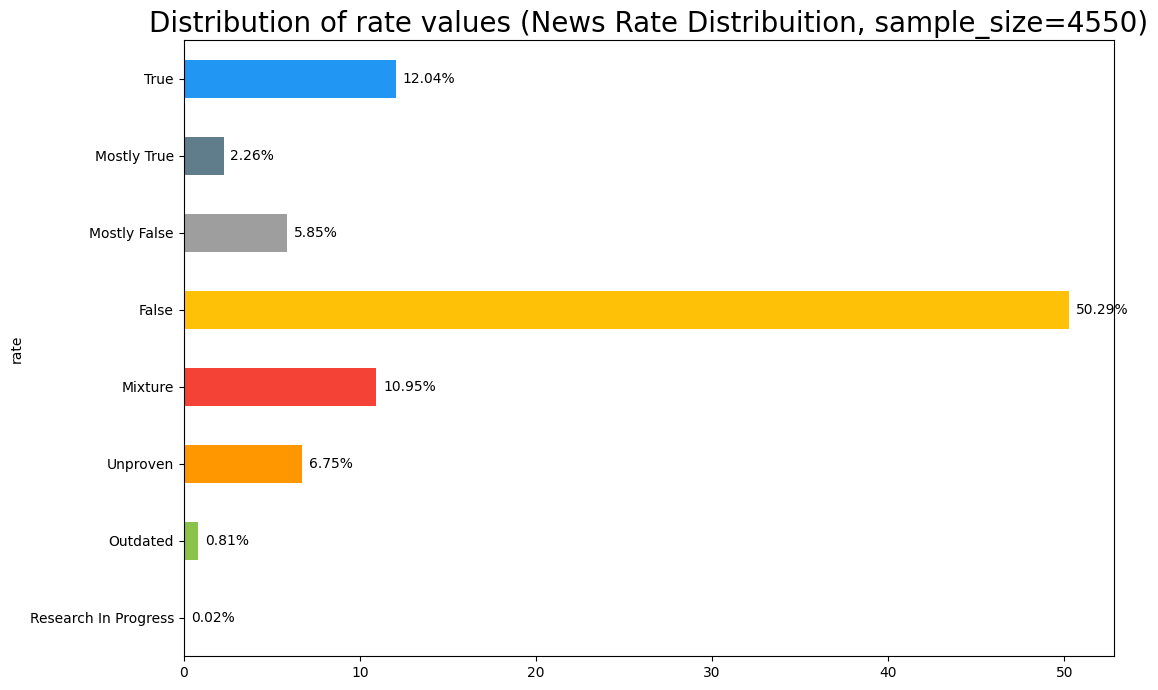

In [35]:
snopes.rate.value_counts()
# Some of the rates were drop this ones are the most important
labels = ['True', 'Mostly True', 'Mostly False','False', 'Mixture', 'Unproven', 'Outdated', 'Research In Progress']
colors = [
    "#4CAF50",  # True - Green
    "#8BC34A",  # Mostly True - Light Green
    "#FF9800",  # Mostly False - Orange
    "#F44336",  # False - Red
    "#FFC107",  # Mixture - Yellow
    "#9E9E9E",  # Unproven - Gray
    "#607D8B",  # Outdated - Blue Gray
    "#2196F3"   # Research In Progress - Blue
]

label_bar_chart(snopes, "News Rate Distribuition", "rate", labels, colors, percent_label=True)

# Seperate Agruments from Facts

We will use severed Bert to train a model to classificate agruments and facts

In [36]:
# Load dataset
agrument_label=pd.read_csv(os.path.join('Datasets','argument_test_train.csv'))

id2label = {
    "Neutral": 0,
    "Counterargument": 1,
    "Restatement": 2,
}
agrument_label["label_map"]=agrument_label["label"].map(id2label)
agrument_label = agrument_label.dropna(subset=["label_map"])
agrument_label.info()
agrument_label.head()

<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, 0 to 745
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   speaker1    745 non-null    object 
 1   statement1  745 non-null    object 
 2   speaker2    745 non-null    object 
 3   statement2  745 non-null    object 
 4   label       745 non-null    object 
 5   label_map   745 non-null    float64
dtypes: float64(1), object(5)
memory usage: 40.7+ KB


,speaker1,statement1,speaker2,statement2,label,label_map
0,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,How are you doing?,Neutral,0.0
1,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Neutral,0.0
2,Vice President Joe Biden,I’m well.,President Donald J. Trump,How are you doing?,Neutral,0.0
3,Vice President Joe Biden,I’m well.,President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Counterargument,1.0
4,Vice President Joe Biden,I’m well.,President Donald J. Trump,And we won the election and therefore we have ...,Counterargument,1.0


# Agrument Analyses
We need to classifie agruments and conteragruments using the agruments of each speaker

## Train Agrument Classifier
The dataset will be use to train and test BERT

This dataset was created by our `Lamma_week_labeling.py` script using `unsloth/llama-3-8b-Instruct-bnb-4bit` model running locally

In [37]:
# Load datasets for training
label2id = {"Neutral": 0, "Counterargument": 1, "Restatement": 2}
id2label = {v: k for k, v in label2id.items()}  # Reverse mapping

agrument_label=pd.read_csv(os.path.join('Datasets','argument_test_train.csv'))

agrument_label["label"].value_counts()
agrument_label = agrument_label[agrument_label["label"] != "Restatement, Counterargument"]
#agrument_label = agrument_label[agrument_label["label"] != "Restatement"]

agrument_label["label_map"]=agrument_label["label"].map(label2id)
agrument_label["label"].value_counts()
agrument_label["label_map"].value_counts()
agrument_label.info()
agrument_label.head()

label
Counterargument                 614
Neutral                         128
Restatement                       3
Restatement, Counterargument      1
Name: count, dtype: int64

label
Counterargument    614
Neutral            128
Restatement          3
Name: count, dtype: int64

label_map
1    614
0    128
2      3
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, 0 to 745
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speaker1    745 non-null    object
 1   statement1  745 non-null    object
 2   speaker2    745 non-null    object
 3   statement2  745 non-null    object
 4   label       745 non-null    object
 5   label_map   745 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 40.7+ KB


,speaker1,statement1,speaker2,statement2,label,label_map
0,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,How are you doing?,Neutral,0
1,Vice President Joe Biden,"How you doing, man?",President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Neutral,0
2,Vice President Joe Biden,I’m well.,President Donald J. Trump,How are you doing?,Neutral,0
3,Vice President Joe Biden,I’m well.,President Donald J. Trump,"Thank you very much, Chris. I will tell you ve...",Counterargument,1
4,Vice President Joe Biden,I’m well.,President Donald J. Trump,And we won the election and therefore we have ...,Counterargument,1


In [38]:
# Train only with one speaker
agrument_label_2=pd.read_csv(os.path.join('Datasets','argument_test_train_2.csv'))
agrument_label_2["label"].value_counts()

agrument_label_2["label_map"]=agrument_label_2["label"].map(label2id)
agrument_label_2["label"].value_counts()
agrument_label_2.info()
agrument_label_2.head()

label
Counterargument    847
Neutral            169
Restatement         74
Name: count, dtype: int64

label
Counterargument    847
Neutral            169
Restatement         74
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speaker1    1090 non-null   object
 1   statement1  1090 non-null   object
 2   speaker2    1090 non-null   object
 3   statement2  1090 non-null   object
 4   label       1090 non-null   object
 5   label_map   1090 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.2+ KB


,speaker1,statement1,speaker2,statement2,label,label_map
0,President Donald J. Trump,I don’t think you have any law enforcement. Yo...,President Donald J. Trump,… they will have the vaccine very soon.,Neutral,0
1,President Donald J. Trump,… they will have the vaccine very soon.,President Donald J. Trump,I don’t think you have any law enforcement. Yo...,Counterargument,1
2,President Donald J. Trump,… they will have the vaccine very soon.,President Donald J. Trump,"No, but you would take a lot of cars off the m...",Counterargument,1
3,President Donald J. Trump,"No, but you would take a lot of cars off the m...",President Donald J. Trump,… they will have the vaccine very soon.,Neutral,0
4,President Donald J. Trump,"No, but you would take a lot of cars off the m...",President Donald J. Trump,This is not going to end well.,Counterargument,1


The dataset bellow will be used as a target set were our BERT model will run on.

In [39]:
debate_1=pd.read_csv(os.path.join('Datasets','us_election_2020_2nd_presidential_debate.csv'))
debate_1.head()
debate_1.info()

,speaker,minute,text
0,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo..."
1,Donald Trump,07:37,How are you doing? How are you?
2,Kristen Welker,07:58,And I do want to say a very good evening to bo...
3,Kristen Welker,08:27,The goal is for you to hear each other and for...
4,Kristen Welker,09:03,… during this next stage of the coronavirus cr...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  512 non-null    object
 1   minute   512 non-null    object
 2   text     512 non-null    object
dtypes: object(3)
memory usage: 12.1+ KB


This function will train our BERT model with the data of `agrument_label` dataset

In [40]:
import evaluate
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset

def tokenize_function(examples):
    return tokenizer(examples["statement1"], examples["statement2"], padding="max_length", truncation=True, return_tensors="pt")

def train_agrument_clasifier(model, statement1_train_list: list, statement2_train_list: list, labels_list: list):

    x = list(zip(statement1_train_list, statement2_train_list))
    y = labels_list

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, stratify=y)

    train_data = Dataset.from_dict({
        'statement1': [t[0] for t in x_train],
        'statement2': [t[1] for t in x_train],
        'label': [int(label) for label in y_train]
    })

    test_data = Dataset.from_dict({
        'statement1': [t[0] for t in x_test],
        'statement2': [t[1] for t in x_test],
        'label': [int(label) for label in y_test]
    })

    print(train_data)
    print(test_data)

    train_data = train_data.map(tokenize_function, batched=True)
    test_data = test_data.map(tokenize_function, batched=True)

    # Remove original text columns (keep only tokenized inputs)
    train_data = train_data.remove_columns(["statement1", "statement2"])
    test_data = test_data.remove_columns(["statement1", "statement2"])

    def compute_metrics(eval_pred):
        metric = evaluate.load("accuracy")
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = metric.compute(predictions=predictions, references=labels)
        return accuracy
    
    print("Min label:", np.min(y_train), "Max label:", np.max(y_train))
    print("Min label:", np.min(y_test), "Max label:", np.max(y_test))

    print(train_data.features)
    print(train_data[:5])  # Print a few samples to check correctness

    training_args = TrainingArguments(
        output_dir="./results",  # output directory
        num_train_epochs=3,  # total # of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=16,  # batch size for evaluation
        warmup_steps=500,  # number of warmup steps for learning rate scheduler
        weight_decay=0.01,  # strength of weight decay
        learning_rate=2e-5,  # learning rate
        save_total_limit=2,  # limit the total amount of checkpoints, delete the older checkpoints
        logging_dir="./logs",  # directory for storing logs
        logging_steps=100,
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        metric_for_best_model="accuracy",  # Metric to use for selecting the best model
        greater_is_better=True,  # Whether a higher value of the metric is better
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,  # training data
        eval_dataset=test_data,  # evaluation data
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.save_model("./new_model")
    tokenizer.save_pretrained("./new_model")

    # Reload with new model
    model = BertForSequenceClassification.from_pretrained("./new_model").to(device)

# Load default model
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=len(label2id), label2id=label2id, id2label=id2label)
model = BertForSequenceClassification.from_pretrained(model_name, config=config).to(device)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Training
statement1_train_list=agrument_label["statement1"].to_list()
statement2_train_list=agrument_label["statement2"].to_list()
labels_list=agrument_label["label_map"].to_list()

train_agrument_clasifier(model, statement1_train_list, statement2_train_list, labels_list)

statement1_train_list=agrument_label_2["statement1"].to_list()
statement2_train_list=agrument_label_2["statement2"].to_list()
labels_list=agrument_label_2["label_map"].to_list()

train_agrument_clasifier(model, statement1_train_list, statement2_train_list, labels_list)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mrduarte/Documents/FCT/samsung/jupyter-env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Dataset({
    features: ['statement1', 'statement2', 'label'],
    num_rows: 484
})
Dataset({
    features: ['statement1', 'statement2', 'label'],
    num_rows: 261
})


Map: 100%|██████████| 484/484 [00:00<00:00, 1234.77 examples/s]
/home/mrduarte/Documents/FCT/samsung/jupyter-env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 261/261 [00:00<00:00, 1159.52 examples/s]


Min label: 0 Max label: 2
Min label: 0 Max label: 2
{'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
{'label': [1, 1, 1, 1, 1], 'input_ids': [[101, 2002, 2253, 1999, 1998, 2057, 2020, 22604, 2008, 1996, 2111, 2057, 2018, 1999, 1996, 2598, 1999, 2859, 2323, 2022, 2583, 2000, 2175, 2000, 8814, 4819, 1998, 5646, 2005, 3209, 2129, 4795, 2023, 2001, 1012, 2002, 2106, 2025, 2130, 3198, 8418, 2000, 2079, 2008, 1012, 102, 2339, 2876, 1521, 1056, 2017, 3437, 2008, 3160, 1029, 2017, 2215, 2000, 2404, 1037, 2843, 1997, 2047, 4259, 2457, 19867, 1012, 7490, 2187, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 55%|█████▍    | 100/183 [00:40<00:33,  2.46it/s]

{'loss': 1.0495, 'grad_norm': 6.2121453285217285, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.64}


100%|██████████| 183/183 [01:16<00:00,  2.39it/s]


{'train_runtime': 76.5625, 'train_samples_per_second': 18.965, 'train_steps_per_second': 2.39, 'train_loss': 0.8167198472987107, 'epoch': 3.0}
Dataset({
    features: ['statement1', 'statement2', 'label'],
    num_rows: 708
})
Dataset({
    features: ['statement1', 'statement2', 'label'],
    num_rows: 382
})


/home/mrduarte/Documents/FCT/samsung/jupyter-env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 708/708 [00:00<00:00, 1076.36 examples/s]
/home/mrduarte/Documents/FCT/samsung/jupyter-env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 382/382 [00:00<00:00, 1130.67 examples/s]


Min label: 0 Max label: 2
Min label: 0 Max label: 2
{'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
{'label': [1, 1, 1, 1, 1], 'input_ids': [[101, 2009, 2253, 2091, 2172, 2062, 1999, 14635, 1012, 102, 2821, 2017, 2288, 2000, 2022, 12489, 2033, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

 37%|███▋      | 100/267 [00:41<01:09,  2.42it/s]

{'loss': 0.6422, 'grad_norm': 4.276009559631348, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.12}


 75%|███████▍  | 200/267 [01:23<00:27,  2.39it/s]

{'loss': 0.5653, 'grad_norm': 9.718178749084473, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.25}


100%|██████████| 267/267 [01:55<00:00,  2.31it/s]


{'train_runtime': 115.4951, 'train_samples_per_second': 18.39, 'train_steps_per_second': 2.312, 'train_loss': 0.583862261825733, 'epoch': 3.0}


Here we do the Classification we pass the speaker_stataments as a list and compara them to find `contradiction`

In [41]:
def classification_agruments(model, speaker1:str ,statement1_list:list, speaker2:str, statement2_list:list, id2label: dict):
    ouput_json=[]
    output_dataframe=pd.DataFrame(columns=["speaker1", "statement1", "speaker2", "statement2", "label", "confidence"])
    
    for i, statement1 in enumerate(statement1_list):
        indices_to_compare = [i-1, i, i+1]
        for j in indices_to_compare:
            if 0 <= j < len(statement2_list):
                statement2 = statement2_list[j]
                model_result=model(f"{statement1} </s></s> {statement2}", truncation=True)
            
                # This is used to create a json output for `Counterargument` only
                if model_result[0]['label'] == "Counterargument":
                    ouput_json.append({
                        f"{speaker1}_statement": statement1,
                        f"{speaker2}_statement": statement2,
                        "relationship": model_result[0]['label'],
                        "confidence": model_result[0]['score']
                    })
                
                # This create a dataframe with all predition of the model
                # Used to be reviewed and train by the model later
                
                new_row = pd.DataFrame([{
                    "speaker1": speaker1,
                    "statement1": statement1,
                    "speaker2": speaker2,
                    "statement2": statement2,
                    "label": model_result[0]['label'],
                    "confidence": model_result[0]['score']
                }])
                output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)
    
    output_dataframe["label"] = output_dataframe["label"].replace(id2label)
    return output_dataframe, ouput_json

In [42]:
from transformers import pipeline

# Use train model
nli_model = pipeline("text-classification", model="./new_model", device=device)
statements_trump=debate_1.loc[debate_1["speaker"] == "Donald Trump", "text"].to_list()
statements_biden=debate_1.loc[debate_1["speaker"] == "Joe Biden", "text"].to_list()

# Make sure they have same size (even if mean miss some text)
min_length = min(len(statements_trump), len(statements_biden))
statements_trump = statements_trump[:min_length]
statements_biden = statements_biden[:min_length]

output_debate1, output_json_debate1=classification_agruments(nli_model, "Donald Trump" ,statements_trump,"Joe Biden", statements_biden, id2label)

#statements_trump=debate_2.loc[debate_2['Speaker']=='Trump']['Statement'].to_list()
#statements_biden=debate_2.loc[debate_2['Speaker']=='Biden']['Statement'].to_list()

#output_debate2, output_json_debate2=classification_agruments(nli_model, "Trump" ,statements_trump, "Biden", statements_biden, id2label)

print("Json Output Debate1")
print(output_json_debate1)
#print("Json Output Debate2")
#print(output_json_debate2)

output_debate1.head()
output_debate1["label"].value_counts()
#output_debate2.head()

/tmp/ipykernel_5679/2948998147.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_dataframe = pd.concat([output_dataframe, new_row], ignore_index=True)


Json Output Debate1
[{'Donald Trump_statement': 'How are you doing? How are you?', 'Joe Biden_statement': '220,000 Americans dead. You hear nothing else I say tonight, hear this. Anyone who is responsible for not taking control. In fact, not saying I take no responsibility initially. Anyone is responsible for that many deaths should not remain as president of the United States of America. We’re in a situation where there are a thousand deaths a day now. A thousand deaths a day. And there are over 70,000 new cases per day. Compared to what’s going on in Europe as the New England Medical Journal said, they’re starting from a very low rate. We’re starting from a very high rate.', 'relationship': 'Counterargument', 'confidence': 0.9369442462921143}, {'Donald Trump_statement': 'How are you doing? How are you?', 'Joe Biden_statement': 'The expectation is we’ll have another 200,000 Americans dead between now and the end of the year. If we just wore these masks, the president’s own advisors ha

,speaker1,statement1,speaker2,statement2,label,confidence
0,Donald Trump,How are you doing? How are you?,Joe Biden,"220,000 Americans dead. You hear nothing else ...",Counterargument,0.936944
1,Donald Trump,How are you doing? How are you?,Joe Biden,"The expectation is we’ll have another 200,000 ...",Counterargument,0.745566
2,Donald Trump,"So as you know, 2.2 million people modeled out...",Joe Biden,"220,000 Americans dead. You hear nothing else ...",Counterargument,0.957253
3,Donald Trump,"So as you know, 2.2 million people modeled out...",Joe Biden,"The expectation is we’ll have another 200,000 ...",Counterargument,0.953221
4,Donald Trump,"So as you know, 2.2 million people modeled out...",Joe Biden,What I would do is make sure we have everyone ...,Counterargument,0.907504


label
Counterargument    351
Neutral             46
Name: count, dtype: int64

In [43]:
# Train the model with the output dataframes
speaker1_debate1_list=output_debate1["statement1"].to_list()
speaker2_debate1_list=output_debate1["statement2"].to_list()
output_debate1["label_map"]=output_debate1["label"].map(label2id)
labels_debate1_list=output_debate1["label_map"].to_list()

#speaker1_debate2_list=output_debate2["statement_speaker1"].to_list()
#speaker2_debate2_list=output_debate2["statement_speaker2"].to_list()

#train_agrument_clasifier(model, tokenizer, output_debate1, speaker1_debate1_list, speaker2_debate1_list)
train_agrument_clasifier(model, speaker1_debate1_list, speaker2_debate1_list, labels_debate1_list)

Dataset({
    features: ['statement1', 'statement2', 'label'],
    num_rows: 258
})
Dataset({
    features: ['statement1', 'statement2', 'label'],
    num_rows: 139
})


/home/mrduarte/Documents/FCT/samsung/jupyter-env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 258/258 [00:00<00:00, 651.73 examples/s]
/home/mrduarte/Documents/FCT/samsung/jupyter-env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 139/139 [00:00<00:00, 651.30 examples/s]


Min label: 0 Max label: 1
Min label: 0 Max label: 1
{'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
{'label': [1, 1, 1, 1, 1], 'input_ids': [[101, 2748, 1012, 2057, 1521, 2128, 2551, 2006, 2009, 2200, 1529, 2057, 1521, 2128, 2667, 2200, 2524, 1012, 2021, 1037, 2843, 1997, 2122, 4268, 2272, 2041, 2302, 1996, 3008, 1012, 2027, 2272, 2058, 2083, 21680, 2015, 1998, 2083, 26880, 1998, 2083, 18542, 1012, 102, 2011, 1996, 2126, 1010, 1996, 7915, 3652, 3068, 1999, 2637, 2003, 1996, 3751, 1010, 8016, 2033, 1010, 5943, 2943, 1998, 3612, 1012, 2002, 6732, 3612, 5320, 4456, 1010, 25367, 2015, 1012, 2009, 1521, 1055, 1996, 7915, 3652, 5841, 1998, 2027, 3477, 2204, 19283, 12678, 1010, 3429, 1010, 2753, 14189, 2019, 3178, 1012, 2057, 2064, 4982, 1998, 2057, 

100%|██████████| 99/99 [00:42<00:00,  2.32it/s]


{'train_runtime': 42.6777, 'train_samples_per_second': 18.136, 'train_steps_per_second': 2.32, 'train_loss': 0.1669305358270202, 'epoch': 3.0}


# Extract Topics from Statements

Let try to extract topics from the statements using Latent Dirichlet Allocation (LDA)

1. Preporcess the raw test
- Tokenize the text - split text in sentence and senstence into words
- Stop words and words with less 3 characters are removed.
- Words are lemmatized:
    - words in third person are changed to first person
    - verbs in past and future are changed into present
- Words are stemmed — words are reduced to their root form.

Note already done by the `standardize_data` function

In [44]:
import gensim
import pyLDAvis.gensim

# Process statements 1 and 2 from output_debate1
if 'statement1_process' and 'statement2_process' not in output_debate1.columns:
    output_debate1.insert(
        output_debate1.columns.get_loc('statement1') + 1,
        'statement1_process',
        output_debate1['statement1'].apply(lambda x: standardize_data(cleaner(x), stop_words))
    )
    output_debate1.insert(
        output_debate1.columns.get_loc('statement2') + 1,
        'statement2_process',
        output_debate1['statement2'].apply(lambda x: standardize_data(cleaner(x), stop_words))
    )

output_debate1.head()
statement1_tokenized = output_debate1["statement1_process"].apply(lambda x: x.split() if isinstance(x, str) else x)
statement2_tokenized = output_debate1["statement2_process"].apply(lambda x: x.split() if isinstance(x, str) else x)

statement1_dictionary = gensim.corpora.Dictionary(statement1_tokenized)
statement2_dictionary = gensim.corpora.Dictionary(statement2_tokenized)

bow_corpus_statement1 = [statement1_dictionary.doc2bow(doc) for doc in statement1_tokenized]
bow_corpus_statement2 = [statement1_dictionary.doc2bow(doc) for doc in statement2_tokenized]

lda_model =  gensim.models.LdaMulticore(bow_corpus_statement1, 
                                   num_topics = 8, 
                                   id2word = statement1_dictionary,                                    
                                   passes = 10,
                                   workers = 2)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus_statement1, statement1_dictionary)
vis

,speaker1,statement1,statement1_process,speaker2,statement2,statement2_process,label,confidence,label_map
0,Donald Trump,How are you doing? How are you?,,Joe Biden,"220,000 Americans dead. You hear nothing else ...",americans dead hear nothing else tonight hear ...,Counterargument,0.936944,1
1,Donald Trump,How are you doing? How are you?,,Joe Biden,"The expectation is we’ll have another 200,000 ...",expectation another americans dead year wear m...,Counterargument,0.745566,1
2,Donald Trump,"So as you know, 2.2 million people modeled out...",know million people model expect close greates...,Joe Biden,"220,000 Americans dead. You hear nothing else ...",americans dead hear nothing else tonight hear ...,Counterargument,0.957253,1
3,Donald Trump,"So as you know, 2.2 million people modeled out...",know million people model expect close greates...,Joe Biden,"The expectation is we’ll have another 200,000 ...",expectation another americans dead year wear m...,Counterargument,0.953221,1
4,Donald Trump,"So as you know, 2.2 million people modeled out...",know million people model expect close greates...,Joe Biden,What I would do is make sure we have everyone ...,would make sure everyone encourage wear mask t...,Counterargument,0.907504,1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=5679) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=5679) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.001028 -0.036624       1        1  23.367590
5      0.008427  0.027165       2        1  20.514303
0     -0.101462  0.001494       3        1  14.613942
1     -0.019203  0.072319       4        1  13.081797
2      0.189204 -0.000514       5        1   8.684576
6      0.019000 -0.248726       6        1   8.248047
4      0.110701  0.139459       7        1   7.522568
7     -0.205638  0.045427       8        1   3.967176, topic_info=         Term       Freq      Total Category  logprob  loglift
246     money  65.000000  65.000000  Default  30.0000  30.0000
617      cage  27.000000  27.000000  Default  29.0000  29.0000
616     build  27.000000  27.000000  Default  28.0000  28.0000
221    happen  35.000000  35.000000  Default  27.0000  27.0000
159    excuse  29.000000  29.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
489     korea   2.440048  11.630561   Topic8  -4.6740   1.6655
355    little   2.439672   8.854217   Topic8  -4.6742   1.9381
553   destroy   2.438694   8.738964   Topic8  -4.6746   1.9508
449     state   2.438491  27.490282   Topic8  -4.6747   0.8047
558  security   2.438487   8.738699   Topic8  -4.6747   1.9507

[483 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
48        5  0.262856     able
48        6  0.262856     able
48        7  0.438093     able
645       3  0.938756  abraham
214       2  0.925322    abuse
...     ...       ...      ...
212       1  0.298024     york
212       3  0.397365     york
212       4  0.248353     york
213       1  0.918976    young
676       3  0.938819     zone

[720 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 1, 2, 3, 7, 5, 8])

## Apply Sentence Tranformer
Use the `sentence-transformers` library to generate dense embeddings for the Agrument and Contragrument. Then compute cosine similarity between the embeddings.

In [45]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similitaries
def compute_cosine_similarity(embeddings_agruments, embeddings_conteragruments, index):
    similarities = model.similarity(embeddings_agruments, embeddings_conteragruments)
    cos_sim_matrix = cosine_similarity(embeddings_agruments)
    cos_sim_sentence = cos_sim_matrix[index]

    top_sentence_indices = cos_sim_sentence.argsort()[-6:-1][::-1]

    return cos_sim_sentence, top_sentence_indices

In [46]:
# Intalize model
model = SentenceTransformer('paraphrase-mpnet-base-v2')

# Generate embeddings - debate1
embeddings_speaker1_debate1=model.encode(output_debate1.loc[output_debate1["label"] == "Counterargument","statement1"].dropna().to_list())
embeddings_speaker2_debate1=model.encode(output_debate1.loc[output_debate1["label"] == "Counterargument","statement2"].dropna().to_list())

cos_sim_sentence_debate, top_sentence_indices_debate = compute_cosine_similarity(embeddings_speaker1_debate1, embeddings_speaker2_debate1, 0)
output_debate1.iloc[top_sentence_indices_debate][['speaker1','statement1']]
output_debate1.iloc[top_sentence_indices_debate][['speaker2','statement2']]

# Generate embeddings - debate2
#embeddings_speaker1_debate2=model.encode(output_debate2.loc[output_debate2["label"] == 0,"statement_speaker1"].dropna().to_list())
#embeddings_speaker2_debate2=model.encode(output_debate2.loc[output_debate2["label"] == 0,"statement_speaker2"].dropna().to_list())

#cos_sim_sentence_debate, top_sentence_indices_debate = compute_cosine_similarity(embeddings_speaker1_debate2, embeddings_speaker2_debate2, 0)
#output_debate2.iloc[top_sentence_indices_debate][['speaker1','statement_speaker1']]
#output_debate2.iloc[top_sentence_indices_debate][['speaker2','statement_speaker2']]

,speaker1,statement1
1,Donald Trump,How are you doing? How are you?
66,Donald Trump,"… think to all of them, including Anthony. I g..."
67,Donald Trump,"… think to all of them, including Anthony. I g..."
68,Donald Trump,"Well, this is what I-"
38,Donald Trump,You certainly did. You certainly did.


,speaker2,statement2
1,Joe Biden,"The expectation is we’ll have another 200,000 ..."
66,Joe Biden,I made it clear and I asked everyone else to t...
67,Joe Biden,"And to the best of my knowledge, I don’t think..."
68,Joe Biden,I made it clear and I asked everyone else to t...
38,Joe Biden,I didn’t say either of those things.


Visualizing embeddings using t-SNE allows to see what arguments and counterarguments are semantically similar.

/tmp/ipykernel_5679/211557128.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


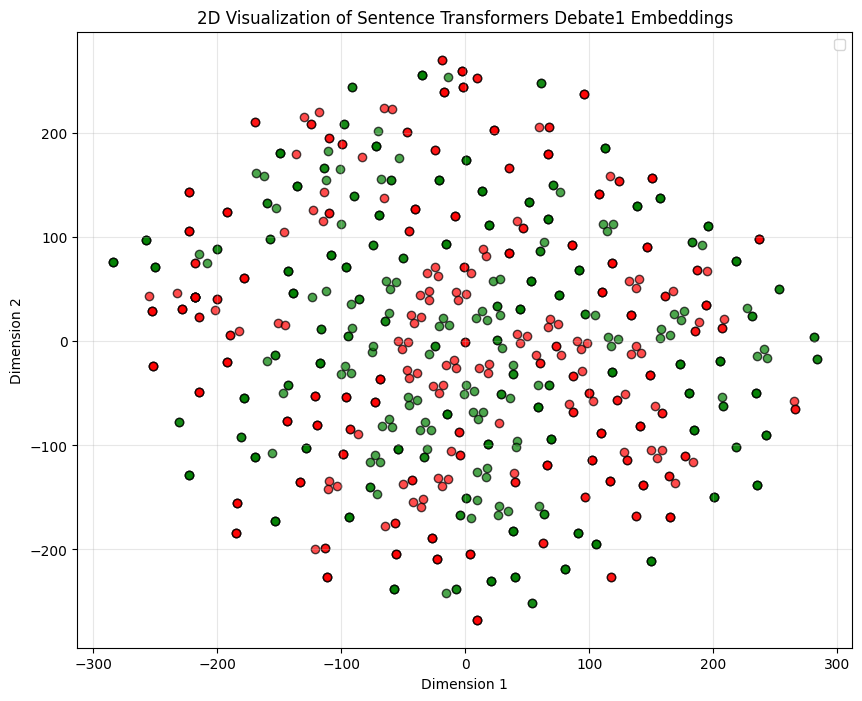

In [47]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Reduce the dimensionality of the embeddings for visualization
def plot_embeddings(embeddings1, embeddings2, title):
    combined_embeddings = np.vstack([embeddings1, embeddings2])
    perplexity = min(30, len(combined_embeddings) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    
    reduced_embeddings = tsne.fit_transform(combined_embeddings)
    reduce_embeddings1 = reduced_embeddings[:len(embeddings1)]
    reduce_embeddings2 = reduced_embeddings[len(embeddings2):]

    plt.figure(figsize=(10, 8))
    #plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', edgecolors='k', alpha=0.7)
    plt.scatter(reduce_embeddings1[:, 0], reduce_embeddings1[:, 1], c='green', edgecolors='k', alpha=0.7)
    plt.scatter(reduce_embeddings2[:, 0], reduce_embeddings2[:, 1], c='red', edgecolors='k', alpha=0.7)
    plt.title(f'2D Visualization of {title} Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Sentence Transformer Visualization
plot_embeddings(embeddings_speaker1_debate1, embeddings_speaker2_debate1,  'Sentence Transformers Debate1')
#plot_embeddings(embeddings_speaker2_debate2, embeddings_speaker2_debate2,  'Sentence Transformers Debate2')